# Data Acquisition

This notebook focuses on downloading and preparing the datasets required for training the LCZ Identification Model and the Air Temperature Estimation Model.

In [513]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import ee
import geemap
from gee_functions import * # custom functions for GEE
from settings import * # global variables for GEE data download

from IPython.display import Image
import folium

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import requests
import pickle

In [207]:
import warnings
warnings.filterwarnings("ignore")

In [219]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----

## Local Climate Zone (LCZ) Training Dataset

### Look for Training Dataset

Additional methods for dataset is here: https://www.tensorflow.org/datasets/overview


In [ ]:
# take a look at the available datasets
tfds.list_builders()

### Download Dataset

To execute only if downloading dataset for the first time

In [4]:
## Only execute if downloading dataset for the first time - RGB only values
# the dataset we want, so2sat is available
ds_so2sat, ds_info = tfds.load('so2sat', split='all', shuffle_files=True, with_info=True)
# check if loading of dataset is successfully
assert isinstance(ds_so2sat, tf.data.Dataset)
# check dataset
print(ds_so2sat)

<_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sample_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentinel1': TensorSpec(shape=(32, 32, 8), dtype=tf.float32, name=None), 'sentinel2': TensorSpec(shape=(32, 32, 10), dtype=tf.float32, name=None)}>


In [4]:
## Only execute if downloading dataset for the first time  - All 10 bands
# the dataset we want, so2sat is available
ds_so2sat, ds_info = tfds.load('so2sat/all', split='all', shuffle_files=True, with_info=True)
# check if loading of dataset is successfully
assert isinstance(ds_so2sat, tf.data.Dataset)
# check dataset
print(ds_so2sat)

<_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sample_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentinel1': TensorSpec(shape=(32, 32, 8), dtype=tf.float32, name=None), 'sentinel2': TensorSpec(shape=(32, 32, 10), dtype=tf.float32, name=None)}>


In [5]:
# check how much disk space has been used
!du -sh ~/* | sort -hr | head -n10

79G	/home/dsisg_yusheng/tensorflow_datasets
7.6G	/home/dsisg_yusheng/miniconda3
21M	/home/dsisg_yusheng/projects
216K	/home/dsisg_yusheng/nohup.out


### Load Dataset

After first download, this can be used to load the dataset in whichever format needed (https://cloud.google.com/storage/docs/public-datasets/sentinel-2)

In [3]:
# load dataset - specify split if need to split into train and validation
ds_so2sat, ds_info = tfds.load('so2sat', split=['train','validation'], with_info=True, download=False)

2023-05-13 03:34:44.286113: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2023-05-13 08:31:31.002684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
2023-05-13 08:31:31.003222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8]
	 [[{{node Placeholder/_2}}]]


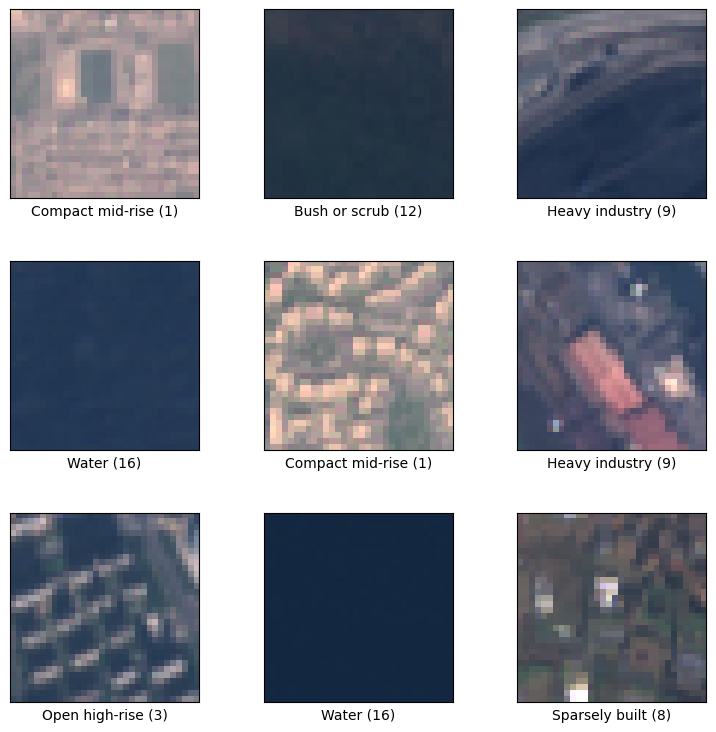

In [119]:
# show examples of train datasets
tfds.show_examples(ds_so2sat[0], ds_info);

In [123]:
# check out size of train and validation datasets
print(f'training dataset size:\t {tf.data.experimental.cardinality(ds_so2sat[0])}')
print(f'validation dataset size: {tf.data.experimental.cardinality(ds_so2sat[1])}')

training dataset size:	 352366
validation dataset size: 24119


----

## Satellite Imagery of Singapore for Local Climate Zone (LCZ) Identification

### Download SENTINEL-2 Data

We use Google Earth Engine to download Sentinel-2 composite images on the fly to reduce disk space usage

We will be using Sentinel-2 MSI: MultiSpectral Instrument, Level-2A ([COPERNICUS/S2_SR](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR))

In [18]:
# Run this only if your account has not been set up for GEE
# create authentication token for accessing Earth Engine API
ee.Authenticate()

Enter verification code:  4/1AbUR2VMegT_StVwY7cOo8YYZrk7_XVLo0vGi3K90ND1wM1TPPVK1TEXZBRg



Successfully saved authorization token.


In [19]:
# Initialise access to Earth Engine
ee.Initialize()

In [23]:
# Define geographical bounds of dataset
singapore_bounds = ee.FeatureCollection('USDOS/LSIB/2017').filter(ee.Filter.eq('COUNTRY_NA', 'Singapore'))
#bounds = Singapore.geometry().bounds()

In [7]:
# define time frame of image
end_date = '2023-05-10'
start_date = datetime.strftime(datetime.strptime('2023-05-10', '%Y-%m-%d') - relativedelta(months=9), format='%Y-%m-%d')

In [58]:
# get image composite without clouds
sen2_cloudless = get_s2_w_cloud_prob(singapore_bounds, start_date, end_date)

sen2_cloudless = (sen2_cloudless.map(add_cloud_shadow_mask)
                                .map(apply_cld_shdw_mask)
                                .mean())

#### Visualisation of Sentinel-2 Composite Image

In [60]:
# Create a folium map object.
center = singapore_bounds.geometry().bounds().centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(sen2_cloudless,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 4000, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)


----

## Weather Station Locations

Before we can download the weather data from data.gov.sg, we need to find the locations of the weather stations so that LST and LCZ information can be downloaded at the same time for greater efficiency

In [4]:
## Get coordinates of weather stations
date_params = {
    'date': '2023-05-12'
}

In [5]:
# get the latest weather data
weather_station_loc = requests.get(WEATHER_URL, date_params).json()


In [6]:
# take only the metadata of the weather stations and make dataframe
weather_station_loc = pd.DataFrame.from_dict(weather_station_loc['metadata']['stations'])

# the location information needs to be exploded
weather_station_loc = pd.concat([weather_station_loc.drop('location', axis=1), weather_station_loc['location'].apply(pd.Series)], axis=1)


In [7]:
weather_station_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         15 non-null     object 
 1   device_id  15 non-null     object 
 2   name       15 non-null     object 
 3   latitude   15 non-null     float64
 4   longitude  15 non-null     float64
dtypes: float64(2), object(3)
memory usage: 728.0+ bytes


In [8]:
weather_station_loc.head()

,id,device_id,name,latitude,longitude
0,S109,S109,Ang Mo Kio Avenue 5,1.3764,103.8492
1,S117,S117,Banyan Road,1.2560,103.6790
2,S50,S50,Clementi Road,1.3337,103.7768
3,S107,S107,East Coast Parkway,1.3135,103.9625
4,S43,S43,Kim Chuan Road,1.3399,103.8878


In [9]:
# save weather station data into csv
weather_station_loc.to_csv('../datasets/weather_station_loc.csv', index=False)

----

## Weather and Land Surface Temperature (LST) Data

For greater efficiency and lower storage needs, we will download the relevant data for only the 320m x 320m square around each weather station

### MODIS Data for LST Estimation

We use Google Earth Engine to download MODIS Land Surface Temperature (LST) data, as this provides the most direct source of LST data. The downside is that it has a much lower resolution of 1km x 1km

We will be using MOD21A1D.061 Terra Land Surface Temperature and 3-Band Emissivity Daily Global 1km ([MODIS/061/MOD21A1D](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD21A1D#bands))


### Overall Workflow
1. For each weather station, we download all the images for LST in 320mx320m grid which has less than 60^ cloud cover
2. We extract the dateime for each valid image
3. For each datetime and weather station, we download the air temperature from NEA
4. For each datetime and weather station, we download the composite Sentinel 2 image of last 9 months 320mx320m grid centred at weather station
5. We merge all the data together

#### Data Download and Merging

In [157]:
# get MODIS image collection from Earth Engine
modis = (ee.ImageCollection('MODIS/061/MOD21A1D')
         .filterDate(ORIGIN_DATE, FINAL_DATE)
         .map(reproject_image)
        )

In [258]:
# get Sentinel2 image collection from Earth Engine
sen2 = get_s2_w_cloud_prob(singapore_bounds,
                           datetime.strftime(datetime.strptime(ORIGIN_DATE, '%Y-%m-%d')-relativedelta(months=9), '%Y-%m-%d'), 
                           FINAL_DATE)

Note: the code below takes a significant amount of time to execute as it is repeatedly calling the data.gov.sg and GEE APIs

In [511]:
# for each weather station
for i, station in weather_station_loc.iterrows():
    
    print(f'Extracting Station {station["id"]} Information...', end='\r')
    
    # get the latlong
    location = (station['longitude'], station['latitude'])
    poi = ee.Geometry.Point(location)
    
    # get all LST images from MODIS centred at this location, where LST is not null
    lst = get_lst(modis, poi)
    
    # for each LST datapoint
    image_df = pd.DataFrame(index=range(lst.shape[0]), columns=['image'])
    airtemp_df = pd.DataFrame(index=range(lst.shape[0]), columns=['airtemp'])
    
    for j, item in lst.iterrows():
        
        # extract datetime
        dt = item['datetime']
        
        # get all Sentinel 2 composite image centred at this location (previous 9 months ending with each LST image)
        aoi = get_tile(poi, SEN2_TILESIZE-10) # define polygon to get, -10 to get a 320m by 320m image
        image = get_sen2_composite_img(sen2, dt) # get Earth Engine image object first
        image = convert_img_to_np(image, aoi)*SEN2_SCALEFACTOR # get np array of image and normalise
        
        # get air temp
        airtemp = get_airtemp(station['id'], dt)
        
        # append to dataframes
        image_df.loc[j, 'image'] = [image]
        airtemp_df.loc[j, 'airtemp'] = airtemp
        
    # append to dataframe - id | lon | lat | datetime | LST | Sen2(nparray) | air temp
    station_df = pd.concat([lst, image_df, airtemp_df], axis=1)
    station_df['id'] = station['id']
    
    # stitch on to consolidated dataset
    if i == 0: # for the first station,
        df = station_df # create the consolidated dataset
    else:
        df = pd.concat([df, station_df], axis=0)
    

Extracting Station S109 Information...Extracting Station S117 Information...Extracting Station S50 Information...Extracting Station S107 Information...Extracting Station S43 Information...Extracting Station S44 Information...Extracting Station S121 Information...Extracting Station S106 Information...Extracting Station S111 Information...Extracting Station S60 Information...Extracting Station S24 Information...Extracting Station S116 Information...Extracting Station S104 Information...Extracting Station S100 Information...Extracting Station S115 Information...

#### Data Cleaning

In [517]:
# convert dtype for lon lat and airtemp to float64
df = df.astype({'longitude': 'float64',
           'latitude': 'float64',
           'airtemp': 'float64'})

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 78
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   1247 non-null   datetime64[ns]
 1   longitude  1247 non-null   float64       
 2   latitude   1247 non-null   float64       
 3   LST        1247 non-null   float64       
 4   image      1247 non-null   object        
 5   airtemp    1088 non-null   float64       
 6   id         1247 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 77.9+ KB


#### Save Dataset

In [520]:
# save dataset as pickle file
pickle.dump(df, open('../datasets/airtemp_train.pkl', 'wb'))
#df.to_csv('../datasets/airtemp_train.csv', index=False)